In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [20]:
df = pd.read_csv("C:\\Users\\Gökhan\\Desktop\\Gökhan\\nids-adversarial\\data\\with_attack_cat_clear_data.csv", low_memory=False)

In [21]:
# # X'e hedefi ve varsa 'label'ı ALMA (label -> leakage)
TARGET = 'attack_cat'
drop_cols = [TARGET]
if 'Label' in df.columns:
    drop_cols.append('Label')
X = df.drop(columns=drop_cols)
y = df[TARGET]
    
# %80 / %20 split (stratified)\n",
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42, shuffle=True
)
print("Train class dist:", y_train.value_counts(normalize=True).round(3))
print("Test class dist:", y_test.value_counts(normalize=True).round(3))

Train class dist: attack_cat
Normal              0.874
Generic             0.085
Exploits            0.018
 Fuzzers            0.008
DoS                 0.006
 Reconnaissance     0.005
 Fuzzers            0.002
Analysis            0.001
Backdoor            0.001
Reconnaissance      0.001
 Shellcode          0.001
Backdoors           0.000
Shellcode           0.000
Worms               0.000
Name: proportion, dtype: float64
Test class dist: attack_cat
Normal              0.874
Generic             0.085
Exploits            0.018
 Fuzzers            0.008
DoS                 0.006
 Reconnaissance     0.005
 Fuzzers            0.002
Analysis            0.001
Backdoor            0.001
Reconnaissance      0.001
 Shellcode          0.001
Backdoors           0.000
Shellcode           0.000
Worms               0.000
Name: proportion, dtype: float64


In [22]:
mlp_params = dict(
    hidden_layer_sizes=(128, 64),  # 2 hidden layer: 128 ve 64 neuron
    activation='relu',
    solver='adam',
    alpha=1e-4,                    # L2 regularization
    learning_rate_init=1e-3,
    max_iter=50,                   # ilk denemede düşük tut, gerekirse artırırsın
    random_state=42
)

mlp_model = Pipeline([
    ("scaler", StandardScaler()),          # feature'ları ölçekle
    ("mlp", MLPClassifier(**mlp_params)),  # MLP modeli
])

In [23]:
X_train.shape, y_train.shape

((2032020, 42), (2032020,))

In [24]:
X_test.shape, y_test.shape

((508006, 42), (508006,))

In [25]:
# 2) Kolon tiplerini belirleyelim
# Sayısal/kategorik ayrımı: object ve category -> kategorik; geri kalan -> sayısal varsayımı
def split_columns(X_train, target):
    cols = [c for c in X_train.columns if c != target]
    cat_cols = []
    num_cols = []

    for c in cols:
        if X_train[c].dtype.name in ["object", "category"]:
            cat_cols.append(c)
        else:
            # Çok-unique ve sayısal görünümlü object'ler varsa dönüştürmeyi düşünebilirsiniz.
            num_cols.append(c)

    return num_cols, cat_cols

num_cols, cat_cols = split_columns(X_train, TARGET)
print("Numeric:", len(num_cols), "\nCategorical:", len(cat_cols))


Numeric: 39 
Categorical: 3


In [26]:
print("Categorical features:", cat_cols)

Categorical features: ['proto', 'state', 'ct_ftp_cmd']


In [27]:
# Counting the unique values of the categorical features...

for col_name in X_train.columns:
    if X_train[col_name].dtypes == 'object':
        unique_cat = len(X_train[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} unique values.".format(col_name = col_name, unique_cat = unique_cat))

Feature 'proto' has 134 unique values.
Feature 'state' has 15 unique values.
Feature 'ct_ftp_cmd' has 9 unique values.


In [28]:
def normalize_col(s: pd.Series):
    return s.astype(str).str.lower().str.strip().fillna("unknown")

def pick_top_categories(s: pd.Series, k=6):
    return normalize_col(s).value_counts().head(k).index.tolist()

def add_binary_flags(df: pd.DataFrame, col: str, keep: list, add_other=True, drop_original=True):
    s = normalize_col(df[col])
    for cat in keep:
        new_col = f"is_{col}_{cat}"
        df[new_col] = (s == cat).astype("uint8")
    if add_other:
        df[f"is_{col}_other"] = (~s.isin(keep)).astype("uint8")
    if drop_original:
        df.drop(columns=[col], inplace=True)
    return df

In [29]:
top_proto = pick_top_categories(X_train['proto'], k=6)

X_train = add_binary_flags(X_train, 'proto', top_proto, add_other=True, drop_original=True)
X_test  = add_binary_flags(X_test,  'proto', top_proto, add_other=True, drop_original=True)

In [30]:
top_state = pick_top_categories(X_train['state'], k = 6)

X_train = add_binary_flags(X_train, 'state', top_state, add_other=True, drop_original=True)
X_test  = add_binary_flags(X_test,  'state', top_state, add_other=True, drop_original=True)

In [31]:
top_ct = pick_top_categories(X_train['ct_ftp_cmd'], k = 6)

X_train = add_binary_flags(X_train, 'ct_ftp_cmd', top_ct, add_other=True, drop_original=True)
X_test  = add_binary_flags(X_test,  'ct_ftp_cmd', top_ct, add_other=True, drop_original=True)

In [33]:
print("\n=== Training Final Model ===")
mlp_model.fit(X_train, y_train)
y_pred = mlp_model.predict(X_test)


=== Training Final Model ===


c:\Users\Gökhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


                  precision    recall  f1-score   support

         Fuzzers     0.6659    0.5446    0.5991      1010
        Fuzzers      0.7126    0.3829    0.4981      3839
 Reconnaissance      0.8225    0.7596    0.7898      2446
      Shellcode      0.8030    0.8372    0.8197       258
        Analysis     0.6000    0.0112    0.0220       535
        Backdoor     0.7647    0.0362    0.0691       359
       Backdoors     0.5000    0.0187    0.0360       107
             DoS     0.4986    0.0544    0.0981      3271
        Exploits     0.5861    0.9130    0.7139      8905
         Generic     0.9955    0.9826    0.9890     43096
          Normal     0.9942    0.9977    0.9959    443749
  Reconnaissance     0.7506    0.9318    0.8314       352
       Shellcode     0.7255    0.8409    0.7789        44
           Worms     0.5000    0.0571    0.1026        35

        accuracy                         0.9800    508006
       macro avg     0.7085    0.5263    0.5246    508006
    weighted

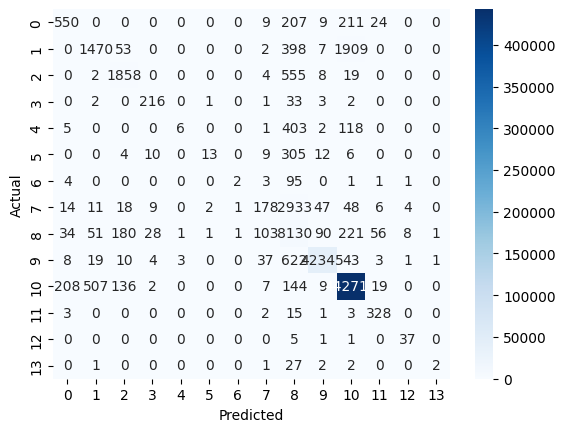

In [34]:
print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
...
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

MLP outputu ile RF outputu farkını al min yap

distilled Model oku ve izle